In [1]:
%matplotlib widget
import gudhi as gd
from gudhi import hera
from gudhi import representations
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from sklearn import manifold
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import scipy.optimize as spo 
from scipy.optimize import minimize
import kmedoids

import os
import math
import time


In [5]:
?kmedoids.KMedoids.fit

Signature: kmedoids.KMedoids.fit(self, X, y=None)
Docstring:
Fit K-Medoids to the provided data.

:param X: Dataset to cluster
:type X: {array-like, sparse matrix}, shape = (n_samples, n_samples)
:param y: ignored

:return: self
File:      ~/.local/lib/python3.10/site-packages/kmedoids/__init__.py
Type:      function


In [2]:
path = "../PersistenceImages/matlab_code/sixShapeClasses/ToyData_PD_TextFiles/"
PDs = {}
for entry in os.scandir(path):
    if(entry.name.endswith(".txt")):
        PDs[entry.name] = {"noise":entry.name.split(sep="_")[2],
                           "index":entry.name.split(sep="_")[3],
                           "shape_class":entry.name.split(sep="_")[4],
                           "dimension":entry.name.split(sep="_")[5],
                           "data":np.loadtxt(entry.path)}

In [3]:
dim = "1"
noise = "1"

In [4]:
persistence_list = [pd["data"] for pd in PDs.values() if(pd["noise"]=="n{}".format(noise) and pd["dimension"]=="{}.txt".format(dim))]

In [5]:
persistence_list_by_shapes= [[pd["data"] for pd in PDs.values() if(pd["noise"]=="n{}".format(noise) and pd["dimension"]=="{}.txt".format(dim) and int(pd["shape_class"])==i)] for i in range(1,7)]

In [6]:
n_train = 10
n_test = len(persistence_list)-n_train

train_diag = []
train_labels = []
test_labels = []
test_diag = []
for i in range(0,6):
    for diag in persistence_list_by_shapes[i][:n_train]:
        train_diag.append(diag)
        train_labels.append(i)
    for diag in persistence_list_by_shapes[i][n_train:]:
        test_diag.append(diag)
        test_labels.append([i])
        
train_labels = np.ravel(train_labels)
test_labels = np.ravel(test_labels)

mean 189.87333333333333
std 38.844012265584624
mean 189.67777777777778
std 39.15633275808306


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
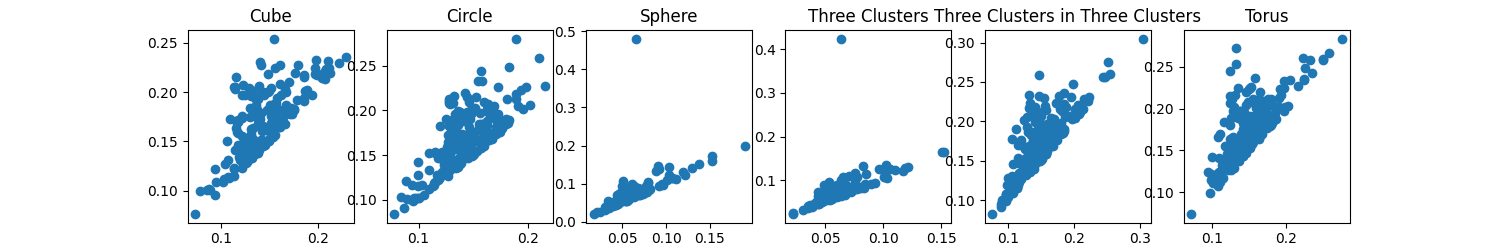

In [7]:
print("mean",np.mean([len(pd) for pd in persistence_list]))
print("std", np.std([len(pd) for pd in persistence_list]))
print("mean",np.mean([len(pd) for pd in test_diag]))
print("std", np.std([len(pd) for pd in test_diag]))
f, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize=(15,2.5))
ax1.scatter(train_diag[0][:,0],train_diag[0][:,1])
ax1.set_title("Cube")

ax2.scatter(train_diag[5][:,0],train_diag[5][:,1])
ax2.set_title("Circle")

ax3.scatter(train_diag[10][:,0],train_diag[10][:,1])
ax3.set_title("Sphere")

ax4.scatter(train_diag[15][:,0],train_diag[15][:,1])
ax4.set_title("Three Clusters")

ax5.scatter(train_diag[20][:,0],train_diag[20][:,1])
ax5.set_title("Three Clusters in Three Clusters")

ax6.scatter(train_diag[25][:,0],train_diag[25][:,1])
ax6.set_title("Torus")


plt.show()


In [8]:
#len(test_diag)
train_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [9]:
l = len(train_diag)
#base = 9
#coefs = [np.log(base)**k/math.factorial(k) for k in range(1,11)]
#coefs = np.array([0]+coefs)
coefs = np.array([0,0,60])
P1 = np.zeros((l,l))
B1 = np.zeros((l,l))
W1 = np.zeros((l,l))
W2 = np.zeros((l,l))
coefs = np.array([0,5,3])
tic = time.time()
for i in range(l):
    diag1 = train_diag[i]
    for j in range(i):
        P1[i,j] = gd.prokhorov_distance(diag1, train_diag[j], coefs=coefs)
        B1[i,j] = gd.bottleneck_distance(train_diag[i], train_diag[j] )
        W1[i,j] = gd.hera.wasserstein_distance(train_diag[i], train_diag[j], order=1, internal_p=1)
        W2[i,j] = gd.hera.wasserstein_distance(train_diag[i], train_diag[j], order=2, internal_p=2)
P1 = P1 + P1.transpose()
B1 = B1 + B1.transpose()
W1 = W1 + W1.transpose()
W2 = W2 + W2.transpose()
print(time.time()-tic)

167.5312910079956


In [10]:
mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(B1).embedding_

ValueError: 'c' argument has 150 elements, which is inconsistent with 'x' and 'y' with size 60.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
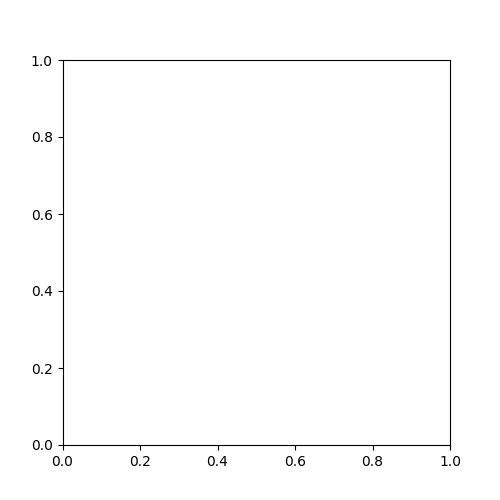

In [11]:
plt.figure(figsize=(5,5))
labels = [int(pd["shape_class"]) for pd in PDs.values() if(pd["noise"]=="n05" and pd["dimension"]=="1.txt")]
#for i in range(0,3):
#    plt.scatter(pos[i*n_iter:(i+1)*n_iter,0], pos[i*n_iter:(i+1)*n_iter, 1], label="{} features".format(i+1))
    #plt.scatter(pos[i*n_iter:(i+1)*n_iter,0], [0]*5 , label="{} features".format(i+1))
plt.scatter(pos[:,0],pos[:,1], c=labels)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc="lower right")
plt.xlabel("MDS from Bottleneck")
plt.show()

In [ ]:
metrics.silhouette_score(B1, labels, metric='precomputed')

In [24]:
def D(r_vals, t):
    return np.min(np.where(np.array(r_vals)<=t))

In [25]:
n_samples = 3
r_vals = [[[None for x in range(n_samples*n_samples)] for y in range(6)] for z in range(6)]
for i in range(0,6):
    for j in range(i,6):
        index=0
        print(i,j)
        for k in range(0, n_samples):
            for l in range(0,n_samples):
                n_points=len(persistence_list_by_shapes[i][-k])+len(persistence_list_by_shapes[j][-l])
                #compute the D function
                d_vals = np.linspace(0,n_points,n_points+1)
                r_vals[i][j][index] = [gd.prokhorov_distance(persistence_list_by_shapes[i][-k], persistence_list_by_shapes[j][-l], np.array([r])) for r in d_vals]
                index = index + 1

0 0
0 1
0 2
0 3
0 4
0 5
1 1
1 2
1 3
1 4
1 5
2 2
2 3
2 4
2 5
3 3
3 4
3 5
4 4
4 5
5 5


In [28]:
fig = plt.figure(figsize = (10,10))
ts = np.linspace(0,2,100)
rs = np.linspace(0,0.25,251)
shape_names = ["Cube", "Circle", "Sphere", "Clusters", "nested Clusters", "Torus"]
for i in range(0,6):
    for j in range(i,6):
        Dmean = np.array([np.mean([D(r,t) for r in r_vals[i][j]]) for t in ts])
        Dstd = np.array([np.std([D(r,t) for r in r_vals[i][j]]) for t in ts])
        col = (i/6,j/6,(j-i)/5)#"tab:blue" if i==j else "tab:orange"
        plt.errorbar(ts,Dmean,Dstd, linestyle='None', marker='o', c=col, ms = 2, label = "{} vs {}".format(shape_names[i],shape_names[j]))
        bp = np.array([gd.bottleneck_profile(persistence_list_by_shapes[i][0], persistence_list_by_shapes[j][0],r0) for r0 in rs])
        plt.plot(rs,rs*(bp**(1/2)))
plt.plot(ts,1000*ts**3, c='k', ls='--', label="$1000 t^3$")
plt.plot(ts,10*ts, c='k', ls='--', label="$10t$")
plt.plot(ts,2500*ts**2, c='k', ls='--', label="$2500 t^2$")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right")

plt.gca().set_ylim((-1,40))

#plt.plot(ts,np.log(141)*ts+np.log(141)/2**2*ts**2+np.log(141)/6**3*ts**3+np.log(141)/24**4*ts**4, color='grey', ls='--')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
trun_pers_list=[]
for i in range(0,6):
    trun_pers_list=trun_pers_list+persistence_list_by_shapes[i][:10]
len(trun_pers_list)

In [12]:
l = len(persistence_list)
#base = 9
#coefs = [np.log(base)**k/math.factorial(k) for k in range(1,11)]
#coefs = np.array([0]+coefs)
coefs = np.array([0,5])
P1 = np.zeros((l,l))

for i in range(l):
    for j in range(i):
        P1[i,j] = gd.prokhorov_distance(persistence_list[i], persistence_list[j], np.array([0,5,3]))
P1 = P1 + P1.transpose()

In [13]:
mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(P1).embedding_

In [ ]:
plt.figure(figsize=(5,5))
labels = [int(pd["shape_class"]) for pd in PDs.values() if(pd["noise"]=="n05" and pd["dimension"]=="1.txt")]
#for i in range(0,3):
#    plt.scatter(pos[i*n_iter:(i+1)*n_iter,0], pos[i*n_iter:(i+1)*n_iter, 1], label="{} features".format(i+1))
    #plt.scatter(pos[i*n_iter:(i+1)*n_iter,0], [0]*5 , label="{} features".format(i+1))
plt.scatter(pos[:,0],pos[:,1], c=labels)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc="lower right")
plt.xlabel("MDS from Bottleneck")
plt.show()

In [14]:
metrics.silhouette_score(P1, labels, metric='precomputed')

-0.09336230299975384

In [15]:
def kmedoids_score(distance_matrix, train_labels):
    c = kmedoids.fasterpam(distance_matrix, len(np.unique(train_labels)), init="build")       
    return sum([train_labels[i] == train_labels[c.medoids[c.labels[i]]] for i in range(0,len(train_labels))])/len(train_labels)


In [16]:
def score_metric(coefs):
    #tic = time.time()
    #PP = sklearn.metrics.pairwise_distances(train_diag, metric = gd.prokhorov_distance, n_jobs=-1, coefs = np.array([6.91132459e-04, 1.10974319e+00, 1.10546464e+01]))
    #BW = sklearn.metrics.pairwise_distances(train_diag, metric = gd.bottleneck_distance, n_jobs=-1)
    #PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs=coefs)
    #PD.fit(train_diag)
    #pm = PD.transform(train_diag)
    l = len(train_diag)
    pm = np.zeros((l,l))

    for i in range(l):
        for j in range(i):
            pm[i,j] = coefs*(gd.bottleneck_profile(train_diag[i], train_diag[j], coefs))**(1/3)
    pm = pm + pm.transpose()
    #print(time.time()-tic)
    #clf = KNeighborsClassifier(metric="precomputed", n_neighbors=3)
    
    #scores = cross_val_score(clf, pm, train_labels, cv=3)
    #print(scores)
    #return(-scores.mean())
    #return(-metrics.silhouette_score(pm, train_labels, metric='precomputed'))
    return -kmedoids_score(pm, train_labels)

In [17]:
cur_best = 1
best_i = 0
best_j =0
for i in range(40,100,1):
    for j in range(0,1):#,25-i,1):
        tic=time.time()
        score = score_metric(i/10000)
        print(i,j, score, "time: ", time.time()-tic)
        if score<=cur_best:
            cur_best = score
            best_i = i
            best_j = j
            
print("best", best_i, best_j, cur_best)

40 0 -0.8833333333333333 time:  1.3805267810821533
41 0 -0.8833333333333333 time:  1.2966258525848389
42 0 -0.8333333333333334 time:  1.3134245872497559
43 0 -0.8333333333333334 time:  1.367356777191162
44 0 -0.8333333333333334 time:  1.3623461723327637
45 0 -0.8833333333333333 time:  1.358952283859253
46 0 -0.85 time:  1.3697772026062012
47 0 -0.8833333333333333 time:  1.359710693359375
48 0 -0.8833333333333333 time:  1.3880689144134521
49 0 -0.9 time:  1.3954269886016846
50 0 -0.9 time:  1.3912580013275146
51 0 -0.8833333333333333 time:  1.380150556564331
52 0 -0.8833333333333333 time:  1.3586828708648682
53 0 -0.8833333333333333 time:  1.3569869995117188
54 0 -0.9 time:  1.3800241947174072
55 0 -0.9 time:  1.3769545555114746
56 0 -0.9 time:  1.415849208831787
57 0 -0.8833333333333333 time:  1.3585844039916992
58 0 -0.9 time:  1.3847856521606445
59 0 -0.9166666666666666 time:  1.3929154872894287
60 0 -0.9166666666666666 time:  1.3868911266326904
61 0 -0.9166666666666666 time:  1.3761

In [18]:
#coefs = np.array([0,best_i,best_j])
res = spo.minimize(score_metric,coefs, method='Nelder-Mead', tol=1e-6)
res

TypeError: bottleneck_profile(): incompatible function arguments. The following argument types are supported:
    1. (diagram_1: numpy.ndarray[numpy.float64], diagram_2: numpy.ndarray[numpy.float64], t: float = None) -> float

Invoked with: array([[0.07716143, 0.08161425],
       [0.08182301, 0.08298707],
       [0.08172373, 0.08447598],
       [0.08715789, 0.08940932],
       [0.09661372, 0.10024736],
       [0.08746945, 0.10076408],
       [0.09454853, 0.1015241 ],
       [0.10404795, 0.10411722],
       [0.09027716, 0.10411722],
       [0.09809873, 0.10556589],
       [0.08447018, 0.10779148],
       [0.09953657, 0.10900524],
       [0.10733792, 0.10919788],
       [0.10689844, 0.10928402],
       [0.11040899, 0.11152944],
       [0.09684332, 0.11203884],
       [0.11262511, 0.11269342],
       [0.10041531, 0.11627876],
       [0.11412094, 0.11681517],
       [0.11009496, 0.11762172],
       [0.11906882, 0.12037091],
       [0.11078894, 0.12052033],
       [0.1205317 , 0.12196091],
       [0.10030543, 0.12225034],
       [0.11211433, 0.12312803],
       [0.11703911, 0.12342577],
       [0.11814683, 0.12463867],
       [0.09761238, 0.12472794],
       [0.10517072, 0.1252262 ],
       [0.12414901, 0.12552486],
       [0.12516701, 0.12577397],
       [0.12645829, 0.12810045],
       [0.12384949, 0.12851943],
       [0.11796018, 0.12854411],
       [0.12462219, 0.12879775],
       [0.11550509, 0.13047164],
       [0.12835225, 0.1308303 ],
       [0.11414422, 0.13101274],
       [0.11319817, 0.1315112 ],
       [0.11104267, 0.13225803],
       [0.12388655, 0.13253196],
       [0.1054931 , 0.13415266],
       [0.13247943, 0.13486849],
       [0.09756833, 0.1355691 ],
       [0.11702143, 0.13591308],
       [0.10857152, 0.13686819],
       [0.13239218, 0.13735918],
       [0.13022796, 0.13742926],
       [0.11788002, 0.13743868],
       [0.10519175, 0.13781572],
       [0.1278189 , 0.13906525],
       [0.12534304, 0.13940094],
       [0.13084555, 0.13949766],
       [0.12431196, 0.13960931],
       [0.12885629, 0.13990383],
       [0.11320176, 0.14039418],
       [0.10813299, 0.14071643],
       [0.1386711 , 0.14241737],
       [0.14032709, 0.14317547],
       [0.12393517, 0.14370016],
       [0.13971688, 0.14403706],
       [0.10039615, 0.14466969],
       [0.11875914, 0.14514416],
       [0.13718174, 0.14617128],
       [0.1225371 , 0.14675236],
       [0.14384239, 0.1480714 ],
       [0.14072938, 0.1489715 ],
       [0.12829503, 0.14928857],
       [0.11025461, 0.15089305],
       [0.15008902, 0.1512202 ],
       [0.14657453, 0.15125093],
       [0.14744721, 0.15258665],
       [0.10881082, 0.15264779],
       [0.13766416, 0.15275473],
       [0.14185775, 0.15285922],
       [0.12920765, 0.15310595],
       [0.14610658, 0.15323348],
       [0.14171703, 0.15364404],
       [0.14133824, 0.15386636],
       [0.13236006, 0.15422288],
       [0.11320238, 0.15451665],
       [0.15125207, 0.15588971],
       [0.15322513, 0.15601757],
       [0.14264134, 0.15618769],
       [0.13680542, 0.15663877],
       [0.10436095, 0.15687682],
       [0.1487936 , 0.1571602 ],
       [0.15681853, 0.15790606],
       [0.11519481, 0.15903896],
       [0.15393447, 0.15908145],
       [0.12232347, 0.16000217],
       [0.15791254, 0.16061751],
       [0.14611581, 0.1612236 ],
       [0.11891866, 0.16194042],
       [0.15909352, 0.16204129],
       [0.11551461, 0.16218844],
       [0.1486345 , 0.16242241],
       [0.15937333, 0.16293142],
       [0.15813836, 0.16354934],
       [0.14165517, 0.16378671],
       [0.15938005, 0.16381307],
       [0.13966705, 0.16569768],
       [0.1619302 , 0.16596834],
       [0.13627095, 0.16612812],
       [0.1629125 , 0.1665462 ],
       [0.15185722, 0.16726685],
       [0.15250386, 0.16832324],
       [0.16262555, 0.1685703 ],
       [0.16130422, 0.16861284],
       [0.16428694, 0.16881265],
       [0.15403841, 0.16893876],
       [0.14563459, 0.16924199],
       [0.15554813, 0.16952886],
       [0.16857826, 0.16976603],
       [0.12440135, 0.17028671],
       [0.12518317, 0.17074958],
       [0.12867251, 0.17137319],
       [0.15136377, 0.17143046],
       [0.17066419, 0.17149273],
       [0.15831643, 0.17163009],
       [0.14948191, 0.17304226],
       [0.17263508, 0.17429727],
       [0.17162171, 0.17431463],
       [0.15986648, 0.17515916],
       [0.12563177, 0.17519001],
       [0.12909842, 0.17580594],
       [0.16054057, 0.17607628],
       [0.14572249, 0.17630981],
       [0.14113075, 0.17637782],
       [0.14286446, 0.17639408],
       [0.16411637, 0.17639408],
       [0.14624193, 0.17720487],
       [0.16234601, 0.17733641],
       [0.16613306, 0.17757055],
       [0.120898  , 0.18019888],
       [0.14337798, 0.1804709 ],
       [0.13841788, 0.1813774 ],
       [0.1717349 , 0.18171113],
       [0.11437628, 0.18172342],
       [0.17704271, 0.18189969],
       [0.16359045, 0.18326838],
       [0.16962512, 0.18350461],
       [0.14278793, 0.18369473],
       [0.15894783, 0.18374639],
       [0.14333563, 0.18497137],
       [0.11654986, 0.1855983 ],
       [0.17147706, 0.18590653],
       [0.17729009, 0.18590653],
       [0.17769575, 0.1859806 ],
       [0.14417881, 0.18606928],
       [0.15868668, 0.18616916],
       [0.14241726, 0.186348  ],
       [0.16383472, 0.18642239],
       [0.17066576, 0.18693557],
       [0.13410728, 0.18710524],
       [0.1856016 , 0.18758205],
       [0.1807126 , 0.18922505],
       [0.14472334, 0.19005529],
       [0.12369435, 0.19017203],
       [0.18642934, 0.19065534],
       [0.13969323, 0.1930199 ],
       [0.13113286, 0.19327517],
       [0.14152372, 0.1933893 ],
       [0.16376259, 0.19450865],
       [0.174438  , 0.19537029],
       [0.19346557, 0.19649821],
       [0.18258182, 0.19700916],
       [0.17156913, 0.19711241],
       [0.16262341, 0.19724392],
       [0.14060148, 0.19744409],
       [0.15033575, 0.19822639],
       [0.13214664, 0.19865394],
       [0.13991884, 0.19895356],
       [0.18173264, 0.19896953],
       [0.12793975, 0.19931484],
       [0.17532061, 0.20107143],
       [0.12402163, 0.20117269],
       [0.13778447, 0.20169019],
       [0.15634528, 0.20213169],
       [0.17267334, 0.20219969],
       [0.1954808 , 0.20307292],
       [0.17685505, 0.2049976 ],
       [0.18126199, 0.20576695],
       [0.18874235, 0.20614771],
       [0.16434158, 0.2067892 ],
       [0.13935137, 0.20733657],
       [0.11702793, 0.20764841],
       [0.19682592, 0.20813091],
       [0.11941619, 0.20856637],
       [0.13252798, 0.20881093],
       [0.11376983, 0.20883121],
       [0.11505862, 0.20891829],
       [0.13618821, 0.20998459],
       [0.14385522, 0.21045909],
       [0.20494844, 0.21065065],
       [0.15854699, 0.21098347],
       [0.14486121, 0.21540184],
       [0.17391226, 0.21588658],
       [0.21139003, 0.21700437],
       [0.1454414 , 0.21706769],
       [0.17180766, 0.21711262],
       [0.19524151, 0.21739445],
       [0.14501665, 0.217616  ],
       [0.1936807 , 0.21796029],
       [0.14511207, 0.21897297],
       [0.18952107, 0.22002529],
       [0.21332075, 0.22015106],
       [0.17379642, 0.2207472 ],
       [0.16444455, 0.22106935],
       [0.20522449, 0.22229525],
       [0.18306608, 0.223056  ],
       [0.15706853, 0.22315755],
       [0.16903722, 0.22437993],
       [0.13465134, 0.22524429],
       [0.14304059, 0.22543918],
       [0.11387452, 0.22669699],
       [0.20119384, 0.22874841],
       [0.23907732, 0.23998328],
       [0.22061534, 0.24053996],
       [0.21395104, 0.24358011],
       [0.21639322, 0.2446178 ],
       [0.20886006, 0.24593127],
       [0.17917735, 0.25026984],
       [0.16214086, 0.25186447],
       [0.15725472, 0.25371928]]), array([[0.07351168, 0.07651278],
       [0.09459776, 0.09558238],
       [0.07823492, 0.09998769],
       [0.08615549, 0.10023927],
       [0.0885441 , 0.10082331],
       [0.08781432, 0.1021096 ],
       [0.10216455, 0.10833325],
       [0.09468239, 0.10917683],
       [0.10357297, 0.11203203],
       [0.10872905, 0.11304862],
       [0.10759032, 0.11370326],
       [0.1135994 , 0.11476982],
       [0.11407498, 0.12189161],
       [0.09411823, 0.1219313 ],
       [0.11421443, 0.12265174],
       [0.12180903, 0.12326753],
       [0.10430011, 0.12656099],
       [0.12568982, 0.12801045],
       [0.12687605, 0.12860836],
       [0.10704217, 0.13070007],
       [0.12300062, 0.13093073],
       [0.11948103, 0.13148369],
       [0.12905332, 0.13230512],
       [0.13203401, 0.1331203 ],
       [0.11875076, 0.13422428],
       [0.13191527, 0.13464666],
       [0.12405613, 0.13465441],
       [0.1215555 , 0.13618411],
       [0.13264453, 0.13688921],
       [0.12605847, 0.13729385],
       [0.13545814, 0.13763526],
       [0.1380129 , 0.13816085],
       [0.1358437 , 0.13908865],
       [0.13767332, 0.13959261],
       [0.13147766, 0.14035533],
       [0.13963482, 0.14105569],
       [0.11447468, 0.14135056],
       [0.11939126, 0.14247466],
       [0.13835596, 0.14300968],
       [0.13153189, 0.1432072 ],
       [0.12463274, 0.14334769],
       [0.12392195, 0.14383297],
       [0.13932364, 0.14413668],
       [0.14173612, 0.1448702 ],
       [0.14093617, 0.14528245],
       [0.1437978 , 0.1452927 ],
       [0.12946969, 0.1452927 ],
       [0.13818347, 0.14561399],
       [0.14273679, 0.14578766],
       [0.13774348, 0.14582484],
       [0.11817531, 0.14642391],
       [0.14545659, 0.14652714],
       [0.12166994, 0.14686954],
       [0.13645757, 0.1479196 ],
       [0.13519533, 0.14803142],
       [0.13212457, 0.14926301],
       [0.12550704, 0.15003409],
       [0.10600082, 0.1503467 ],
       [0.14962059, 0.15048677],
       [0.14850171, 0.15097137],
       [0.14278379, 0.15098618],
       [0.14193502, 0.15128569],
       [0.15034579, 0.1515944 ],
       [0.12592427, 0.15206575],
       [0.12477139, 0.15217753],
       [0.13373771, 0.15235263],
       [0.12514348, 0.15338638],
       [0.12829628, 0.15347892],
       [0.13110472, 0.15421272],
       [0.15419253, 0.15435555],
       [0.12201031, 0.15588678],
       [0.15579017, 0.15647744],
       [0.13085066, 0.15704017],
       [0.15440832, 0.15715249],
       [0.11828585, 0.15879778],
       [0.11708177, 0.15985269],
       [0.15399862, 0.15990751],
       [0.15390086, 0.16017918],
       [0.14933721, 0.16067576],
       [0.14272812, 0.16091509],
       [0.14687465, 0.16170546],
       [0.15411306, 0.16210642],
       [0.13146575, 0.16249452],
       [0.15255978, 0.16291496],
       [0.11611244, 0.16324001],
       [0.13345541, 0.16339001],
       [0.16036908, 0.16447269],
       [0.1513803 , 0.16456651],
       [0.16127615, 0.16482384],
       [0.14863914, 0.16505529],
       [0.14317927, 0.16608955],
       [0.15910016, 0.16641406],
       [0.13983716, 0.16649097],
       [0.15821228, 0.16670592],
       [0.13886365, 0.16683329],
       [0.16654303, 0.16749742],
       [0.13848598, 0.16753132],
       [0.16172261, 0.16797629],
       [0.1644475 , 0.16863895],
       [0.15175234, 0.1687266 ],
       [0.16431945, 0.16929936],
       [0.11790832, 0.16987052],
       [0.11617626, 0.17030711],
       [0.11785662, 0.17079442],
       [0.15584588, 0.17131269],
       [0.15426336, 0.17167259],
       [0.11776947, 0.17222065],
       [0.14062704, 0.17251363],
       [0.13851187, 0.17251626],
       [0.10946713, 0.17255549],
       [0.16067561, 0.17255838],
       [0.12202103, 0.17406746],
       [0.1297352 , 0.17431441],
       [0.16387123, 0.17487581],
       [0.1588639 , 0.17498309],
       [0.13750053, 0.17537197],
       [0.12180688, 0.1755455 ],
       [0.15213295, 0.1755834 ],
       [0.13505399, 0.17630805],
       [0.15358628, 0.17690688],
       [0.17405184, 0.17747285],
       [0.13364987, 0.17747285],
       [0.17180493, 0.17786321],
       [0.1661443 , 0.17814426],
       [0.14038912, 0.17852137],
       [0.16096856, 0.17875178],
       [0.13456627, 0.17875178],
       [0.16048275, 0.17900075],
       [0.14112867, 0.17904639],
       [0.1409512 , 0.17916272],
       [0.15712833, 0.17943983],
       [0.13684288, 0.17961821],
       [0.16326658, 0.1797969 ],
       [0.17063102, 0.18036108],
       [0.1480031 , 0.18165285],
       [0.1754829 , 0.18178342],
       [0.13795893, 0.18198969],
       [0.1598963 , 0.1821115 ],
       [0.13765485, 0.18231523],
       [0.16508276, 0.18240939],
       [0.15015757, 0.18243403],
       [0.17539508, 0.1825472 ],
       [0.15454747, 0.18254913],
       [0.15406215, 0.18377051],
       [0.15393205, 0.18385669],
       [0.13069878, 0.18397596],
       [0.13608005, 0.18398163],
       [0.16851747, 0.18404615],
       [0.167992  , 0.18415347],
       [0.17295416, 0.18440552],
       [0.13648654, 0.18654765],
       [0.1671026 , 0.18655569],
       [0.15073898, 0.18732438],
       [0.15516568, 0.18847771],
       [0.15732268, 0.18878001],
       [0.18605714, 0.19081994],
       [0.17901071, 0.19196307],
       [0.13825601, 0.19351974],
       [0.15772248, 0.19386897],
       [0.18615872, 0.19433545],
       [0.13556102, 0.19451527],
       [0.13168254, 0.19576608],
       [0.12509851, 0.19723987],
       [0.16231368, 0.19728386],
       [0.14492318, 0.19744277],
       [0.1938755 , 0.19750253],
       [0.12210224, 0.19760804],
       [0.1323076 , 0.1990242 ],
       [0.141178  , 0.19916382],
       [0.16762835, 0.19969337],
       [0.1433009 , 0.20033086],
       [0.14865426, 0.2004518 ],
       [0.1501792 , 0.20079761],
       [0.1321142 , 0.2008781 ],
       [0.1873002 , 0.20140095],
       [0.18918895, 0.20178379],
       [0.13142054, 0.20251857],
       [0.16675621, 0.20297584],
       [0.11495515, 0.20312287],
       [0.15222388, 0.20377693],
       [0.12871761, 0.20436263],
       [0.11446924, 0.20492868],
       [0.11375112, 0.20551045],
       [0.13966256, 0.20630089],
       [0.12300803, 0.20706109],
       [0.1616698 , 0.20874907],
       [0.17017659, 0.21035331],
       [0.20762357, 0.21295076],
       [0.20495626, 0.21393976],
       [0.18575517, 0.21492387],
       [0.11606613, 0.21558843],
       [0.19902789, 0.2175343 ],
       [0.18565076, 0.21785044],
       [0.14897462, 0.21811966],
       [0.20022053, 0.2181842 ],
       [0.19769212, 0.21892053],
       [0.17669272, 0.21909264],
       [0.21244798, 0.21916536],
       [0.20752548, 0.22177605],
       [0.20839659, 0.22362602],
       [0.19694847, 0.22419731],
       [0.21200993, 0.22473844],
       [0.15635235, 0.22485859],
       [0.14165714, 0.22713468],
       [0.16103507, 0.22715252],
       [0.18017764, 0.22760375],
       [0.22245982, 0.22972037],
       [0.14016675, 0.23080944],
       [0.21075908, 0.23182769],
       [0.19850857, 0.23285127],
       [0.22933891, 0.23536103],
       [0.15549566, 0.25424258]]), array([0., 5.])

In [19]:
coefs = np.array([0,0,2500])

In [20]:
tic = time.time()
PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs=coefs)#res.x)
PD.fit(train_diag)
pm = PD.transform(test_diag)
print("Prokhorov done in ",time.time()-tic)

Prokhorov done in  19.776302337646484


In [21]:
tic = time.time()
BD = gd.representations.BottleneckDistance(n_jobs = -1)
BD.fit(train_diag)
bd = BD.transform(test_diag)
print("Bottleneck done in ",time.time()-tic)

tic = time.time()
WD1 = gd.representations.WassersteinDistance(n_jobs = -1, internal_p=1, order=1)
WD1.fit(train_diag)
wd1 = WD1.transform(test_diag)
print("1-Wasserstein done in ",time.time()-tic)

tic = time.time()
WD2 = gd.representations.WassersteinDistance(n_jobs = -1, internal_p=2, order=2)
WD2.fit(train_diag)
wd2 = WD2.transform(test_diag)
print("2-Wasserstein done in ",time.time()-tic)

Bottleneck done in  16.127475023269653
1-Wasserstein done in  22.31323552131653
2-Wasserstein done in  93.49001288414001


In [22]:
clf = KNeighborsClassifier(metric="precomputed")
clf.fit(P1, train_labels)
print("Prokhorov score ",clf.score(pm,test_labels))

clf.fit(B1, train_labels)
print("Bottleneck score ",clf.score(bd,test_labels))

clf.fit(W1, train_labels)
print("1-Wasserstein score ",clf.score(wd1,test_labels))

clf.fit(W2, train_labels)
print("2-Wasserstein score ",clf.score(wd2,test_labels))

ValueError: Found input variables with inconsistent numbers of samples: [150, 60]

In [23]:
tic = time.time()
PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs=coefs)
PD.fit(test_diag)
pm = PD.transform(test_diag)
print("Prokhorov done in ",time.time()-tic)

tic = time.time()
BD = gd.representations.BottleneckDistance(n_jobs = -1)
BD.fit(test_diag)
bd = BD.transform(test_diag)
print("Bottleneck done in ",time.time()-tic)

Prokhorov done in  10.87638235092163
Bottleneck done in  9.967697381973267


In [24]:
tic = time.time()
WD1 = gd.representations.WassersteinDistance(n_jobs = -1, internal_p=1, order=1)
WD1.fit(test_diag)
wd1 = WD1.transform(test_diag)
print("1-Wasserstein done in ",time.time()-tic)

tic = time.time()
WD2 = gd.representations.WassersteinDistance(n_jobs = -1, internal_p=2, order=2)
WD2.fit(test_diag)
wd2 = WD2.transform(test_diag)
print("2-Wasserstein done in ",time.time()-tic)

1-Wasserstein done in  14.20799446105957
2-Wasserstein done in  63.17891025543213


In [25]:
tic = time.time()
coefs = 0.0061
l = len(test_diag)
BP = np.zeros((l,l))
p=2

for i in range(l):
    for j in range(i):
        BP[i,j] = coefs*(gd.bottleneck_profile(test_diag[i], test_diag[j], coefs))**(1/p)
BP = BP + BP.transpose()
print("Lower bound W2 done in ",time.time()-tic)

UP = np.zeros((l,l))

tic = time.time()
for i in range(l):
    for j in range(i):
        UP[i,j] = coefs*(gd.bottleneck_profile(test_diag[i], test_diag[j], coefs)*(bd[i][j]**p-coefs**p)+coefs**p*(len(test_diag[i])+len(test_diag[j])))**(1/p)
UP = UP + UP.transpose()
print("Upper bound W2 done in ",time.time()-tic)

tic = time.time()
AW = np.sqrt(BP*UP)
print("Approx W2 done in ",time.time()-tic)


Lower bound W2 done in  3.154001235961914
Upper bound W2 done in  3.1284286975860596
Approx W2 done in  0.00010824203491210938


In [26]:

#print("Prokhorov score ",kmedoids_score(pm,test_labels))

print("Bottleneck score ",kmedoids_score(bd,test_labels))

print("1-Wasserstein score ",kmedoids_score(wd1,test_labels))

print("2-Wasserstein score ",kmedoids_score(wd2,test_labels))

print("Lower Bound W2 score ",kmedoids_score(BP,test_labels))

print("Upper Bound W2 score ",kmedoids_score(UP,test_labels))

print("Approx W2 score ",kmedoids_score(AW,test_labels))


Bottleneck score  0.6666666666666666
1-Wasserstein score  0.9444444444444444
2-Wasserstein score  0.9777777777777777
Lower Bound W2 score  0.9111111111111111
Upper Bound W2 score  0.6666666666666666
Approx W2 score  0.8333333333333334


In [63]:

print("Prokhorov score ",metrics.silhouette_score(pm,test_labels, metric='precomputed'))

print("Bottleneck score ",metrics.silhouette_score(bd,test_labels, metric='precomputed'))

print("1-Wasserstein score ",metrics.silhouette_score(wd1,test_labels, metric='precomputed'))

print("2-Wasserstein score ",metrics.silhouette_score(wd2,test_labels, metric='precomputed'))

Prokhorov score  0.23854885986917668
Bottleneck score  0.37850633548613916
1-Wasserstein score  0.6365006460772956
2-Wasserstein score  0.5997947023173017


In [76]:
len(persistence_list_by_shapes[1])

25

In [79]:
kmedoids_score(W2, train_labels)

0.6